<a href="https://colab.research.google.com/github/daeun118/MachineLearning1/blob/main/88_333333_%EB%B0%B4%EB%93%9C%ED%8C%8C%EC%9B%8C%20%EC%A0%81%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = np.load("/content/drive/MyDrive/train.npy", allow_pickle=True)
data = data.item()
data_input = data['input']


In [ ]:
labels = data['label']


In [ ]:
data_input

array([[[[-2.8890e+00],
         [-7.9550e+00],
         [-1.6170e+00],
         ...,
         [ 1.9430e+00],
         [-3.0920e+00],
         [-1.7090e+00]],

        [[-3.3770e+00],
         [-8.9310e+00],
         [-1.6170e+00],
         ...,
         [ 2.9200e+00],
         [-3.0920e+00],
         [ 2.4400e-01]],

        [[-3.3770e+00],
         [-8.9310e+00],
         [-1.5300e-01],
         ...,
         [ 3.4080e+00],
         [-3.0920e+00],
         [ 2.1970e+00]],

        ...,

        [[ 5.9000e+00],
         [ 3.7640e+00],
         [-8.9420e+00],
         ...,
         [-1.0000e-02],
         [ 5.2080e+00],
         [-1.9775e+01]],

        [[ 5.4120e+00],
         [ 3.2760e+00],
         [-1.0895e+01],
         ...,
         [-1.0000e-02],
         [ 5.2080e+00],
         [-2.1240e+01]],

        [[ 5.9000e+00],
         [ 2.7870e+00],
         [-1.1383e+01],
         ...,
         [-1.0000e-02],
         [ 5.6970e+00],
         [-2.2217e+01]]],


       [[[-3.8660e+00],


In [ ]:
labels.shape

(1080,)

In [ ]:
# 미리 스플릿
X_train, X_valid, y_train, y_valid = train_test_split(data_input,labels , test_size=0.2, random_state=156)


In [ ]:
print("X_train.shape:", X_train.shape)
print("X_valid.shape:", X_valid.shape)

X_train.shape: (864, 256, 64, 1)
X_valid.shape: (216, 256, 64, 1)


# **전처리**


In [ ]:
y_valid.mean()

0.5

In [ ]:
y_train.shape

(864,)

In [ ]:
X_train.shape

(864, 256, 64, 1)

In [ ]:
# X_train reshape

X_train_1 = []
for i in range(864):
    data_input_m = X_train[i][:][:].squeeze().T
    X_train_1.append(data_input_m)

input_T_train = np.array(X_train_1)
input_T_train.shape


(864, 64, 256)

In [ ]:
# X_valid reshape

X_valid_1 = []
for i in range(216):
    data_input_m = X_valid[i][:][:].squeeze().T
    X_valid_1.append(data_input_m)

input_T_valid = np.array(X_valid_1)
input_T_valid.shape


(216, 64, 256)

In [ ]:
data_input_train = input_T_train.reshape(864*64,256)
data_input_train.shape


(55296, 256)

In [ ]:
data_input_valid = input_T_valid.reshape(216*64,256)
data_input_valid.shape


(13824, 256)

In [ ]:
# train label 확장

repeated_arr_train = []
for i in range(len(y_train)):
    repeated_arr_train.extend(np.full(64, y_train[i]))

labels_train = np.array(repeated_arr_train)
labels_train.shape


(55296,)

In [ ]:
# valid label 확장

repeated_arr_valid = []
for i in range(len(y_valid)):
    repeated_arr_valid.extend(np.full(64, y_valid[i]))

labels_valid = np.array(repeated_arr_valid)
labels_valid.shape


(13824,)

In [ ]:
print("labels_train.mean():", labels_train.mean())
print("labels_valid.mean():", labels_valid.mean())

labels_train.mean(): 0.5
labels_valid.mean(): 0.5


## 스케일링

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(data_input_train)
# X_valid_scaled = scaler.transform(data_input_valid)

# print(X_train_scaled.shape)
# print(X_valid_scaled.shape)


In [ ]:
# 노치 필터

import numpy as np
from scipy.signal import iirnotch, filtfilt

def apply_notch_filter(data, notch_freq, fs, quality_factor=30):
    """
    주어진 데이터에 노치 필터를 적용하여 특정 주파수의 잡음을 제거합니다.

    :param data: 필터링할 데이터 (numpy 배열)
    :param notch_freq: 제거할 잡음의 주파수 (Hz)
    :param fs: 샘플링 주파수 (Hz)
    :param quality_factor: 노치 필터의 품질 계수 (높을수록 필터의 반응이 좁아집니다)
    :return: 필터링된 데이터
    """
    b, a = iirnotch(notch_freq, quality_factor, fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [ ]:
# 샘플링 주파수 설정 (예: 500 Hz)
fs = 500

# 노치 필터 적용
alpha_band_train = apply_notch_filter(data_input_train, 50, fs)
alpha_band_valid = apply_notch_filter(data_input_valid, 50, fs)

alpha_band_train = apply_notch_filter(alpha_band_train, 60, fs)
alpha_band_valid = apply_notch_filter(alpha_band_valid, 60, fs)


## FFT 변환

In [ ]:
def fft(eeg_signal, sampling_rate):
    """
    주어진 EEG 신호에 대한 FFT를 계산하고 주파수 및 해당 주파수 성분의 파워를 시각화합니다.

    :param eeg_signal: EEG 신호 (1차원 numpy 배열)
    :param sampling_rate: 샘플링 주파수 (Hz)
    """
    n = len(eeg_signal)
    T = 1 / sampling_rate
    yf = np.fft.fft(eeg_signal)
    xf = np.fft.fftfreq(n, T)[:n//2]
    yf = 2.0/n * np.abs(yf[:n//2])
    return yf


In [ ]:
FFT_train = []

# X_train_scaled는 (55296, 256) 형태
# 여기서 각 행은 전체 EEG 시그널을 나타내며, 이를 FFT 함수에 전달
for i in range(55296):
    FFT_train.append(fft(alpha_band_train[i], 500))  # 각 행 전체를 fft 함수에 전달


In [ ]:
FFT_valid = []

# X_valid_scaled의 형태는 (13824, 256)으로, 이는 216개의 트라이얼 각각에 대해 64개 채널이 있음을 의미합니다.
# 따라서, 216 * 64 = 13824 개의 행이 각각 하나의 채널 데이터를 나타냅니다.
for i in range(13824):
    FFT_valid.append(fft(alpha_band_valid[i], 500))



In [ ]:
# 리스트 -> numpy array

FFT_train = np.array(FFT_train)
FFT_valid = np.array(FFT_valid)


In [ ]:
print("FFT_train shape:", FFT_train.shape)
print("FFT_valid shape:", FFT_valid.shape)

FFT_train shape: (55296, 128)
FFT_valid shape: (13824, 128)


In [185]:
import numpy as np

def enhanced_band_power(fft_data, sampling_rate):
    """
    주파수 대역을 0.5Hz 간격으로 세분화하여 각 세그먼트의 평균 파워를 계산합니다.

    :param fft_data: FFT 결과 (numpy 배열, 각 행이 하나의 채널의 FFT 결과)
    :param sampling_rate: 샘플링 주파수 (Hz)
    :return: 각 주파수 대역의 평균 파워를 포함하는 numpy 배열
    """
    freqs = np.fft.fftfreq(fft_data.shape[1] * 2, 1 / sampling_rate)[:fft_data.shape[1]]
    max_freq = sampling_rate / 2
    num_bands = int(max_freq / 1)  # 0.5Hz 간격으로 분할

    # 주파수 대역 정의
    band_indices = [np.logical_and(freqs >= i*0.5, freqs < (i+1)*0.5) for i in range(num_bands)]

    # 각 대역의 평균 파워 계산
    band_powers = np.zeros((fft_data.shape[0], num_bands))
    for i, idx in enumerate(band_indices):
        if np.any(idx):
            band_powers[:, i] = np.nanmean(fft_data[:, idx], axis=1)
        else:
            band_powers[:, i] = 0  # 데이터가 없는 경우 0 할당

    return band_powers




In [186]:
# FFT_train과 FFT_valid에 band_power 함수 적용
band_power_train = np.vstack([enhanced_band_power(FFT_train[i * 64:(i + 1) * 64], 500) for i in range(864)])
band_power_valid = np.vstack([enhanced_band_power(FFT_valid[i * 64:(i + 1) * 64], 500) for i in range(216)])

print("band_power_train shape:", band_power_train.shape)
print("band_power_valid shape:", band_power_valid.shape)


band_power_train shape: (55296, 250)
band_power_valid shape: (13824, 250)


## FFT 변환 시각화

In [179]:
def plot_fft(eeg_signal, sampling_rate):
    """
    주어진 EEG 신호에 대한 FFT를 계산하고 주파수 및 해당 주파수 성분의 파워를 시각화합니다.

    :param eeg_signal: EEG 신호 (1차원 numpy 배열)
    :param sampling_rate: 샘플링 주파수 (Hz)
    """
    n = len(eeg_signal)
    T = 1 / sampling_rate
    yf = np.fft.fft(eeg_signal)
    xf = np.fft.fftfreq(n, T)[:n//2]
    yf = 2.0/n * np.abs(yf[:n//2])

    plt.plot(xf, yf)
    plt.title('FFT of EEG Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.grid()
    plt.show()
    return yf
# 예시 EEG 신호 (임의의 데이터)

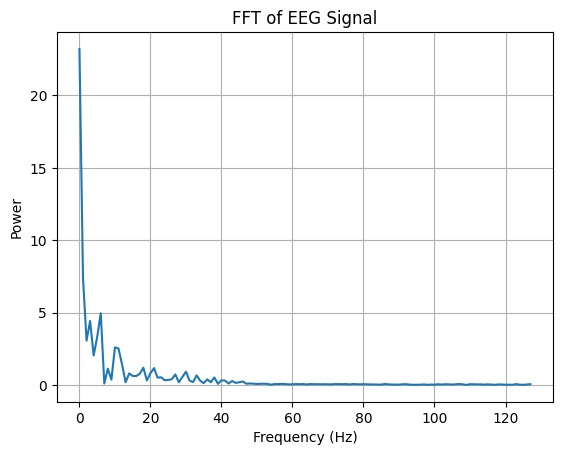

array([2.32124297e+01, 7.39727351e+00, 3.06894727e+00, 4.42350641e+00,
       2.04653686e+00, 3.32333305e+00, 4.95583010e+00, 1.11390852e-01,
       1.13541211e+00, 3.76369215e-01, 2.60596953e+00, 2.52410638e+00,
       1.42890794e+00, 1.94491529e-01, 8.04532430e-01, 6.31421831e-01,
       6.26039264e-01, 7.84921205e-01, 1.20480108e+00, 3.23776881e-01,
       8.16760056e-01, 1.17735882e+00, 5.15384908e-01, 5.40246823e-01,
       3.38450554e-01, 3.53137652e-01, 4.05031204e-01, 7.37651869e-01,
       1.94775045e-01, 5.61499044e-01, 9.28446927e-01, 3.13349934e-01,
       2.07703945e-01, 6.71633378e-01, 3.04581567e-01, 1.35989832e-01,
       3.99290758e-01, 1.95829168e-01, 5.24845064e-01, 9.11595671e-02,
       3.27431677e-01, 3.12425393e-01, 1.09365903e-01, 2.81273513e-01,
       1.54512210e-01, 1.93560842e-01, 2.52088120e-01, 9.50604462e-02,
       1.12249336e-01, 9.41320129e-02, 8.04821745e-02, 8.88367097e-02,
       9.72894315e-02, 7.70925600e-02, 2.92022069e-02, 7.18577886e-02,
      

In [180]:
plot_fft(input_T_train[0][0], 256)

## PCA

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=90) # pca 모델 생성
# pca.fit(X_train_scaled) # pca 모델 학습

# X_train_pca = pca.transform(X_train_scaled)
# X_valid_pca = pca.transform(X_valid_scaled)

# explained_variance_ratio = pca.explained_variance_ratio_
# print("설명 분산 비율:", explained_variance_ratio)
# print("누적 설명 분산 비율:", sum(explained_variance_ratio))
# # 누적 설명 분산 비율이 95% 이상이 되게 n_components 설정

# **모델 간 성능비교**

## XGBoost

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

# # 모델 초기화
# XG_model = XGBClassifier(n_estimators=600, max_depth=15, learning_rate=0.01,
#                          subsample=0.7, colsample_bytree=0.5, gamma=1.5, reg_lambda=5,
#                          reg_alpha=5, min_child_weight=5, random_state=0)
# XG_model.fit(band_power_train, labels_train)

# # 예측
# y_valid_pred_xg = XG_model.predict(band_power_valid)
# y_train_pred_xg = XG_model.predict(band_power_train) # train 정확도 확인용

# # accuracy 확인(train/val)
# train_accuracy_xg = accuracy_score(labels_train, y_train_pred_xg)
# valid_accuracy_xg = accuracy_score(labels_valid, y_valid_pred_xg)

# print("XGBoost train Accuracy:", train_accuracy_xg)
# print("XGBoost Validation Accuracy:", valid_accuracy_xg)

# # y_valid_pred_xg.mean()
# print()
# print("XGBoost y_valid_pred_xg.mean():", y_valid_pred_xg.mean())


XGBoost train Accuracy: 0.76904296875
XGBoost Validation Accuracy: 0.6935763888888888

XGBoost y_valid_pred_xg.mean(): 0.5102719907407407


In [ ]:
# import xgboost as xgb
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt

# # 모델 초기화
# XG_model = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1,
#                          subsample=0.3, colsample_bytree=0.5, gamma=1.5, reg_lambda=10,
#                          reg_alpha=10, min_child_weight=6, random_state=0)

# # 학습과 동시에 평가 결과를 저장
# eval_set = [(band_power_train, labels_train), (band_power_valid, labels_valid)]

# # 모델 훈련
# XG_model.fit(band_power_train, labels_train, early_stopping_rounds=50,
#               eval_metric="logloss", eval_set=eval_set, verbose=True)

# # evals_result_ 속성을 사용해 결과 저장
# evals_result = XG_model.evals_result()

# # 예측
# y_train_pred_xg = XG_model.predict(band_power_train)
# y_valid_pred_xg = XG_model.predict(band_power_valid)

# # 정확도 계산
# train_accuracy_xg = accuracy_score(labels_train, y_train_pred_xg)
# valid_accuracy_xg = accuracy_score(labels_valid, y_valid_pred_xg)

# print("XGBoost Train Accuracy:", train_accuracy_xg)
# print("XGBoost Validation Accuracy:", valid_accuracy_xg)
# print("XGBoost y_valid_pred_xg.mean():", y_valid_pred_xg.mean())

# # 로스 그래프 그리기
# epochs = len(evals_result['validation_0']['logloss'])
# x_axis = range(0, epochs)

# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['validation_0']['logloss'], label='Train')
# ax.plot(x_axis, evals_result['validation_1']['logloss'], label='Valid')
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')
# plt.show()



In [234]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 모델 초기화
XG_model = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1,
                         subsample=0.5, colsample_bytree=1, gamma=1.5, reg_lambda=5,
                         reg_alpha=5, min_child_weight=8, random_state=0)

XG_model.fit(band_power_train, labels_train, early_stopping_rounds=50,
              eval_metric="logloss", eval_set=[(band_power_valid, labels_valid)], verbose=True)

# 예측
y_valid_pred_xg = XG_model.predict(band_power_valid)
y_train_pred_xg = XG_model.predict(band_power_train) # train 정확도 확인용

# accuracy 확인(train/val)
train_accuracy_xg = accuracy_score(labels_train, y_train_pred_xg)
valid_accuracy_xg = accuracy_score(labels_valid, y_valid_pred_xg)

print("XGBoost train Accuracy:", train_accuracy_xg)
print("XGBoost Validation Accuracy:", valid_accuracy_xg)

# y_valid_pred_xg.mean()
print()
print("XGBoost y_valid_pred_xg.mean():", y_valid_pred_xg.mean())


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68262
[1]	validation_0-logloss:0.67328
[2]	validation_0-logloss:0.66470
[3]	validation_0-logloss:0.65827
[4]	validation_0-logloss:0.65230
[5]	validation_0-logloss:0.64651
[6]	validation_0-logloss:0.64189
[7]	validation_0-logloss:0.63757
[8]	validation_0-logloss:0.63345
[9]	validation_0-logloss:0.63004
[10]	validation_0-logloss:0.62653
[11]	validation_0-logloss:0.62458
[12]	validation_0-logloss:0.62200
[13]	validation_0-logloss:0.61958
[14]	validation_0-logloss:0.61660
[15]	validation_0-logloss:0.61442
[16]	validation_0-logloss:0.61306
[17]	validation_0-logloss:0.61074
[18]	validation_0-logloss:0.60879
[19]	validation_0-logloss:0.60715
[20]	validation_0-logloss:0.60566
[21]	validation_0-logloss:0.60417
[22]	validation_0-logloss:0.60272
[23]	validation_0-logloss:0.60150
[24]	validation_0-logloss:0.60026
[25]	validation_0-logloss:0.59941
[26]	validation_0-logloss:0.59845
[27]	validation_0-logloss:0.59724
[28]	validation_0-logloss:0.59631
[29]	validation_0-loglos

In [235]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels_valid, y_valid_pred_xg)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[4897 2015]
 [1971 4941]]


ROC AUC: 0.7857785009062339


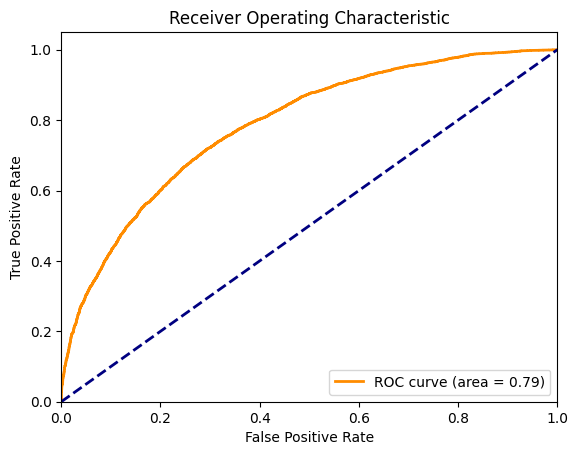

In [236]:
fpr, tpr, thresholds = roc_curve(labels_valid, XG_model.predict_proba(band_power_valid)[:, 1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## CatBoost

In [ ]:
pip install catboost

In [209]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=1000,           # 부스팅 라운드 수
    learning_rate=0.03,        # 학습률
    depth=6,                   # 트리의 깊이
    l2_leaf_reg=3,             # L2 정규화 계수
    border_count=32,           # 수치형 피처의 분할 수
    loss_function='Logloss',   # 최적화할 손실 함수
    random_state=0,            # 결과 재현을 위한 랜덤 시드
    verbose=0                  # 학습 중 메시지 출력 설정 (0은 출력 안 함)
)

catboost_model.fit(band_power_train, labels_train)

y_valid_pred_cat = catboost_model.predict(band_power_valid)
y_train_pred_cat = catboost_model.predict(band_power_train) # train 정확도 확인용

# accuracy 확인(train/val)
train_accuracy_cat = accuracy_score(labels_train, y_train_pred_cat)
valid_accuracy_cat = accuracy_score(labels_valid, y_valid_pred_cat)

print("CatBoost train Accuracy:", train_accuracy_cat)
print("CatBoost Validation Accuracy:", valid_accuracy_cat)

# y_valid_pred_cat.mean()
print()
print("CatBoost y_valid_pred_cat.mean():", y_valid_pred_cat.mean())


CatBoost train Accuracy: 0.7986472800925926
CatBoost Validation Accuracy: 0.7103587962962963

CatBoost y_valid_pred_cat.mean(): 0.5102719907407407


----

## RF

In [212]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, max_depth = 12,
                                  min_samples_split= 5, min_samples_leaf =6,  random_state=0)
rf_model.fit(band_power_train, labels_train)

# 검증 세트에서 예측 수행
y_valid_pred_rf = rf_model.predict(band_power_valid)
y_train_pred_rf = rf_model.predict(band_power_train) # train 정확도 확인용

# 랜덤 포레스트 모델의 정확도 확인
train_accuracy_rf = accuracy_score(labels_train, y_train_pred_rf)
valid_accuracy_rf = accuracy_score(labels_valid, y_valid_pred_rf)

print("Random Forest train Accuracy:", train_accuracy_rf)
print("Random Forest Validation Accuracy:", valid_accuracy_rf)

# 랜덤 포레스트 모델의 예측값의 평균 확인
print()
print("Random Forest y_valid_pred_rf.mean():", y_valid_pred_rf.mean())

Random Forest train Accuracy: 0.8366608796296297
Random Forest Validation Accuracy: 0.6728877314814815

Random Forest y_valid_pred_rf.mean(): 0.5130208333333334


## 앙상블

In [213]:
from sklearn.ensemble import VotingClassifier

# VotingClassifier 초기화
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', XG_model),
        ('catboost', catboost_model),
        ('rf', rf_model)
    ], voting='hard'
)

# 모델 학습
voting_clf.fit(band_power_train, labels_train)

# 모델 평가
y_train_pred_voting = voting_clf.predict(band_power_train)
y_valid_pred_voting = voting_clf.predict(band_power_valid)

train_accuracy_voting = accuracy_score(labels_train, y_train_pred_voting)
valid_accuracy_voting = accuracy_score(labels_valid, y_valid_pred_voting)

print("Voting Ensemble Train Accuracy:", train_accuracy_voting)
print("Voting Ensemble Validation Accuracy:", valid_accuracy_voting)


Voting Ensemble Train Accuracy: 0.8376012731481481
Voting Ensemble Validation Accuracy: 0.7058738425925926


#*TEST 파일 load 및 csv export*#


In [237]:
data_test = np.load("/content/drive/MyDrive/test.npy", allow_pickle=True)
data_test = data_test.item()
data_input_test = data_test['input']

In [238]:
input_T_test = []
for i in range(120):
    data_input_m = data_input_test[i][:][:].squeeze().T
    input_T_test.append(data_input_m)

input_T_test = np.array(input_T_test)
input_T_test.shape

(120, 64, 256)

In [239]:
data_input_test = input_T_test.reshape(120*64,256)
data_input_test.shape

(7680, 256)

In [ ]:
# X_test_scaled = scaler.transform(data_input_test)

# print(X_test_scaled.shape)

In [240]:
# 샘플링 주파수 설정 (예: 500 Hz)
fs = 500

# 노치 필터 적용
alpha_band_test = apply_notch_filter(data_input_test, 50, fs)

alpha_band_test = apply_notch_filter(alpha_band_test, 60, fs)


In [241]:
FFT_test = []

# X_valid_scaled의 형태는 (7680, 256)으로, 이는 120개의 트라이얼 각각에 대해 64개 채널이 있음을 의미합니다.
# 따라서, 120 * 64 = 7680 개의 행이 각각 하나의 채널 데이터를 나타냅니다.
for i in range(7680):
    FFT_test.append(fft(data_input_test[i], 500))

In [242]:
# 리스트 -> numpy array

FFT_test = np.array(FFT_test)

In [243]:
# FFT_test에 band_power 함수 적용
band_power_test = np.vstack([enhanced_band_power(FFT_test[i * 64:(i + 1) * 64], 500) for i in range(120)])


print("band_power_test shape:", band_power_test.shape)


band_power_test shape: (7680, 250)


In [244]:
y_test_pred_xg = XG_model.predict(band_power_test)

In [245]:
y_test_pred_xg.mean()

0.5536458333333333

In [246]:
csv = list(y_test_pred_xg)

In [247]:
len(csv)

7680

In [248]:
answer = []

for i in range(120):
    pred = []
    for s in range(64):
        pred.append(csv[i*64+s])
    if sum(pred)/len(pred) > 0.55:
        answer.append(1)
    else:
        answer.append(0)

len(answer)

120

In [249]:
test_pred = np.array(answer)

In [250]:
test_pred.mean()

0.5166666666666667

In [251]:
# 제출하기
id=np.arange(120)
target=answer

submission_df=pd.DataFrame({'ID':id, 'Target':target})

submission_df

,ID,Target
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
115,115,0
116,116,1
117,117,0
118,118,0


In [252]:
submission_df.mean()

ID        59.500000
Target     0.516667
dtype: float64

In [254]:
submission_df.to_csv('submission_05053.csv',index = False)